# Step 1 - Import libraries

In [53]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import hvplot.pandas
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

from yahoo_fin.stock_info import *

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Load CSV as DataFrame
aapl_df = pd.read_csv(Path("AAPL_5yr.csv"))
aapl_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,25.652500,26.342501,25.500000,26.337500,24.323219,270597600
1,2016-01-05,26.437500,26.462500,25.602501,25.677500,23.713696,223164000
2,2016-01-06,25.139999,25.592501,24.967501,25.174999,23.249626,273829600
3,2016-01-07,24.670000,25.032499,24.107500,24.112499,22.268383,324377600
4,2016-01-08,24.637501,24.777500,24.190001,24.240000,22.386133,283192000


In [61]:
stocks = ["ANZ.AX"]

# Step 2 - Extracting Data

In [70]:
# Import ticker data from yahoo finance
aapl_df = get_data(stocks[0], start_date = "01/01/2019", end_date = "31/12/2019", index_as_date = True, interval = "1d")
aapl_df.head()

,open,high,low,close,adjclose,volume,ticker
2019-01-01,24.440001,24.440001,23.809999,23.860001,21.209906,4061443,ANZ.AX
2019-01-02,24.030001,24.389999,23.879999,24.340000,21.636593,5152249,ANZ.AX
2019-01-03,24.170000,24.299999,23.950001,24.250000,21.556589,5078668,ANZ.AX
2019-01-06,24.510000,24.700001,24.450001,24.590000,21.858826,3746194,ANZ.AX
2019-01-07,24.639999,24.969999,24.430000,24.860001,22.098839,4936433,ANZ.AX


# Step 3 - MACD calculation

In [71]:
# Create MACD data
ewm_fast = aapl_df["close"].ewm(span = 12, adjust = False).mean()
ewm_slow = aapl_df["close"].ewm(span = 26, adjust = False).mean()
macd = pd.DataFrame(ewm_fast - ewm_slow).rename(columns = {"close":"macd"})
macd.head()

,macd
2019-01-01,0.000000
2019-01-02,0.038291
2019-01-03,0.060674
2019-01-06,0.104643
2019-01-07,0.159437


In [72]:
# Create Signal line data
signal = pd.DataFrame(macd["macd"].ewm(span = 9, adjust = False).mean()).rename(columns = {"macd":"signal"})
signal.head()

,signal
2019-01-01,0.000000
2019-01-02,0.007658
2019-01-03,0.018261
2019-01-06,0.035538
2019-01-07,0.060317


In [73]:
# Create histogram
histogram = pd.DataFrame(macd["macd"] - signal["signal"]).rename(columns = {0:"hist"})
histogram.head()

,hist
2019-01-01,0.000000
2019-01-02,0.030632
2019-01-03,0.042413
2019-01-06,0.069105
2019-01-07,0.099119


In [74]:
# Concat data into one dataframe
data = pd.concat([macd, signal, histogram], join = "inner", axis = 1)
data.head()

,macd,signal,hist
2019-01-01,0.000000,0.000000,0.000000
2019-01-02,0.038291,0.007658,0.030632
2019-01-03,0.060674,0.018261,0.042413
2019-01-06,0.104643,0.035538,0.069105
2019-01-07,0.159437,0.060317,0.099119


# Step 4 - Plot MACD data

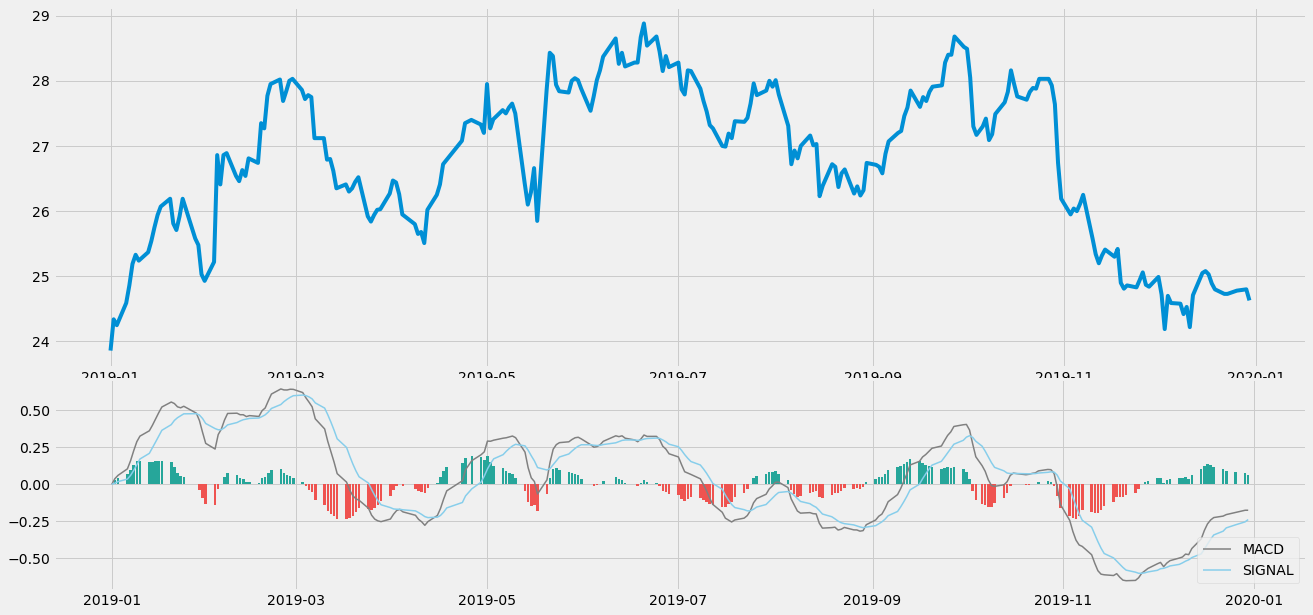

In [75]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    # Conditional where if positive and negative trends are coloured
    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(aapl_df['close'], data['macd'], data['signal'], data['hist'])

# Step 5 - Create the Trading strategy

In [76]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    # For loop for range of dates
    for i in range(len(data)):
        # Conditional produce signal to buy stock
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        # Conditional produce signal to sell stock
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(aapl_df['close'], data)

# Step 6 - Plotting the Trading lists

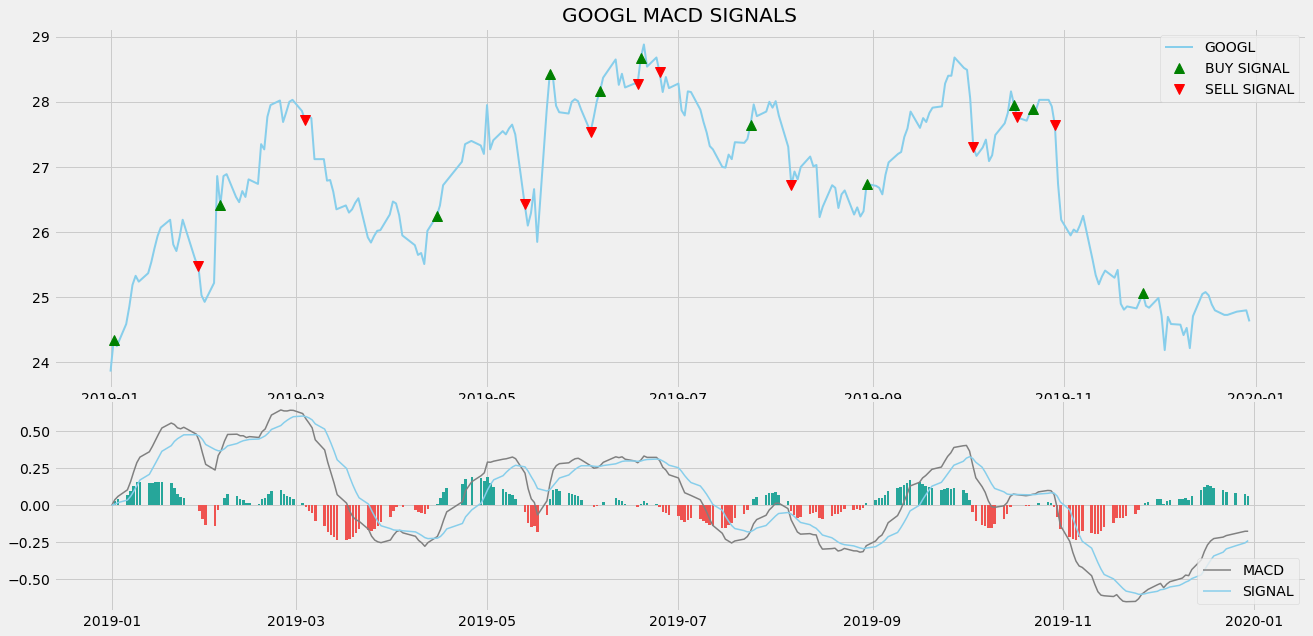

In [77]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(aapl_df['close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(aapl_df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(aapl_df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
ax2.plot(data['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(data['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(data)):
    if str(data['hist'][i])[0] == '-':
        ax2.bar(data.index[i], data['hist'][i], color = '#ef5350')
    else:
        ax2.bar(data.index[i], data['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

# Step 7 - Create position on stock

In [78]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(aapl_df['close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = data['macd']
signal = data['signal']
close_price = aapl_df['close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(aapl_df.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(aapl_df.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,macd,signal,macd_signal,macd_position
2019-01-01,23.860001,0.000000,0.000000,0,1
2019-01-02,24.340000,0.038291,0.007658,1,1
2019-01-03,24.250000,0.060674,0.018261,0,1
2019-01-06,24.590000,0.104643,0.035538,0,1
2019-01-07,24.860001,0.159437,0.060317,0,1
...,...,...,...,...,...
2019-12-22,24.730000,-0.215069,-0.317116,0,1
2019-12-23,24.730000,-0.204874,-0.294668,0,1
2019-12-26,24.780001,-0.190563,-0.273847,0,1
2019-12-29,24.799999,-0.175584,-0.254194,0,1


# Step 8 - Backtesting

In [ ]:
# Set initial capital
initial_capital = float(100000)

# Set share size
share_size = 500

# Take a 500 share position where the 